In [68]:
import torch.nn.functional as Fun
import torch
import numpy as np
torch.manual_seed(100)

from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [71]:
training_data = datasets.CIFAR100(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=lambda y: torch.zeros(100, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
)

test_data = datasets.CIFAR100(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=lambda y: torch.zeros(100, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
)

Files already downloaded and verified
Files already downloaded and verified


Original Images


C:\Users\etern\AppData\Local\Temp\ipykernel_7620\755860063.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)
C:\Users\etern\AppData\Local\Temp\ipykernel_7620\755860063.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for 

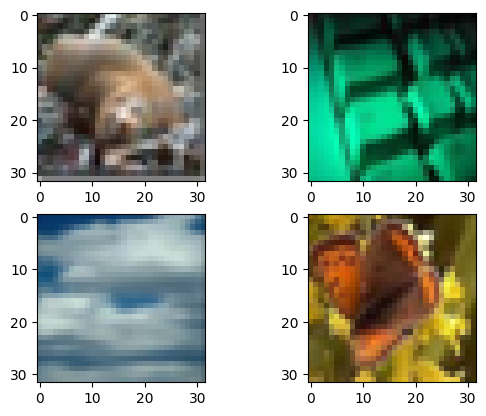

CutMix Images


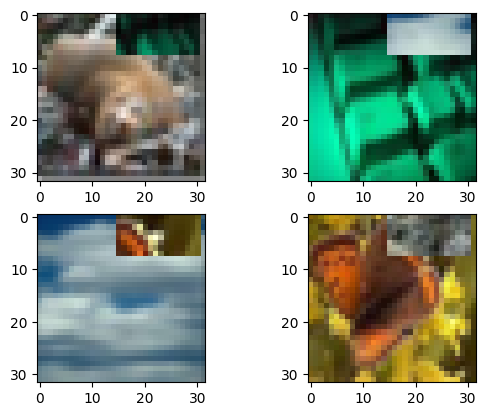

Original labels:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Updated labels
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.1250, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.8750, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0

In [106]:
def rand_bbox(size, lamb):
    """ Generate random bounding box 
    Args:
        - size: [width, breadth] of the bounding box
        - lamb: (lambda) cut ratio parameter, sampled from Beta distribution
    Returns:
        - Bounding box
    """
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lamb)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
def generate_cutmix_image(image_batch, image_batch_labels, beta):
    """ Generate a CutMix augmented image from a batch 
    Args:
        - image_batch: a batch of input images
        - image_batch_labels: labels corresponding to the image batch
        - beta: a parameter of Beta distribution.
    Returns:
        - CutMix image batch, updated labels
    """
    # generate mixed sample
    lam = np.random.beta(beta, beta)
    #print(lam)
    rand_index = np.random.permutation(len(image_batch))
    target_a = image_batch_labels
    target_b = image_batch_labels[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(image_batch[0][0].shape, lam)
    image_batch_updated = image_batch.numpy().copy()
    image_batch_updated[:, :, bbx1:bbx2, bby1:bby2] = image_batch[rand_index, :, bbx1:bbx2, bby1:bby2]
    
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (image_batch.shape[3] * image_batch.shape[2]))
    label = target_a * lam + target_b * (1. - lam)
    
    return torch.Tensor(image_batch_updated),label


# Generate CutMix image
# Let's use the first image of the batch as the input image to be augmented
for x, y in train_dataloader:
    image_batch = x
    image_batch_labels = y
    break
input_image = image_batch[0]
image_batch_updated, image_batch_labels_updated = generate_cutmix_image(image_batch[:4], image_batch_labels[:4], 1.0)

# Show original images
print("Original Images")
for i in range(2):
    for j in range(2):
        plt.subplot(2,2,2*i+j+1)
        #plt.imshow(image_batch[2*i+j].numpy())
        plt.imshow(np.moveaxis(image_batch[2*i+j].numpy(),0,-1))
plt.show()


# Show CutMix images
print("CutMix Images")
for i in range(2):
    for j in range(2):
        plt.subplot(2,2,2*i+j+1)
        #plt.imshow(image_batch_updated[2*i+j])
        plt.imshow(np.moveaxis(image_batch_updated[2*i+j].numpy(),0,-1))
plt.show()

# Print labels
print('Original labels:')
print(image_batch_labels)
print('Updated labels')
print(image_batch_labels_updated)

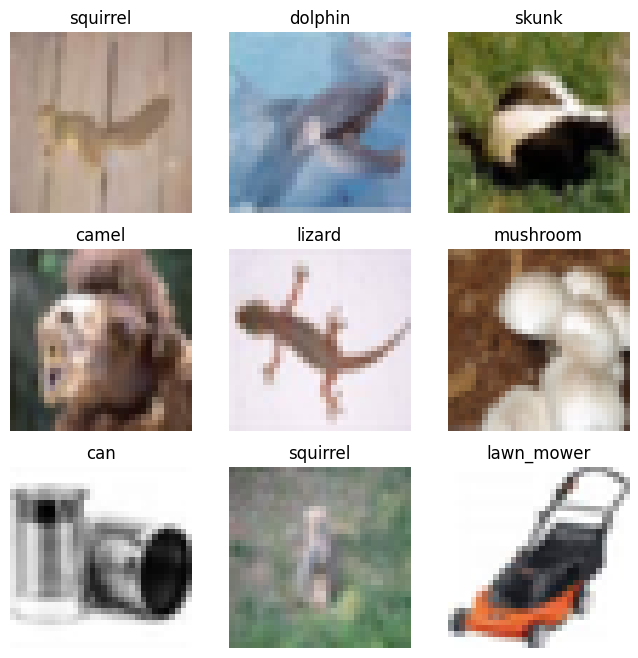

In [4]:
classes = """0: apple
1: aquarium_fish
2: baby
3: bear
4: beaver
5: bed
6: bee
7: beetle
8: bicycle
9: bottle
10: bowl
11: boy
12: bridge
13: bus
14: butterfly
15: camel
16: can
17: castle
18: caterpillar
19: cattle
20: chair
21: chimpanzee
22: clock
23: cloud
24: cockroach
25: couch
26: cra
27: crocodile
28: cup
29: dinosaur
30: dolphin
31: elephant
32: flatfish
33: forest
34: fox
35: girl
36: hamster
37: house
38: kangaroo
39: keyboard
40: lamp
41: lawn_mower
42: leopard
43: lion
44: lizard
45: lobster
46: man
47: maple_tree
48: motorcycle
49: mountain
50: mouse
51: mushroom
52: oak_tree
53: orange
54: orchid
55: otter
56: palm_tree
57: pear
58: pickup_truck
59: pine_tree
60: plain
61: plate
62: poppy
63: porcupine
64: possum
65: rabbit
66: raccoon
67: ray
68: road
69: rocket
70: rose
71: sea
72: seal
73: shark
74: shrew
75: skunk
76: skyscraper
77: snail
78: snake
79: spider
80: squirrel
81: streetcar
82: sunflower
83: sweet_pepper
84: table
85: tank
86: telephone
87: television
88: tiger
89: tractor
90: train
91: trout
92: tulip
93: turtle
94: wardrobe
95: whale
96: willow_tree
97: wolf
98: woman
99: worm"""

labels = classes.split()[1::2]
len(labels)
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item() # Случайный индекс из датасета
    img, label = training_data[sample_idx] # Обращение по такому индексу возвращает изображение и метку элемента датасета
    figure.add_subplot(rows, cols, i)
    plt.title(labels[label])
    plt.axis("off")
    plt.imshow(np.moveaxis(img.numpy(),0,-1))
plt.show()

In [5]:
img.numpy().shape

(3, 32, 32)

In [73]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [7]:
from torch import nn

In [225]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3, 3), stride=2, padding=(1, 1), bias=True),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3, 3), stride=2, padding=(1, 1), bias=True),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=True),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=True),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(3, 3), stride=2, padding=(2, 2), bias=True),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.Conv2d(in_channels=4, out_channels=4, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=True),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.Conv2d(in_channels=4, out_channels=4, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=True),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.Conv2d(in_channels=4, out_channels=4, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=True),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.Flatten(),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            #nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3, 3), stride=2, padding=(1, 1), bias=True),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            #nn.LeakyReLU(0.1),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3, 3), stride=2, padding=(1, 1), bias=True),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            #nn.LeakyReLU(0.1),
            #nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=True),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            #nn.LeakyReLU(0.1),
            #nn.MaxPool2d((3, 3), stride=(2, 2)),
            #nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=True),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            #nn.LeakyReLU(0.1),
            #nn.MaxPool2d((3, 3), stride=(2, 2)),
            #nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(3, 3), stride=2, padding=(2, 2), bias=True),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            #nn.LeakyReLU(0.1),
            #nn.MaxPool2d((3, 3), stride=(2, 2)),
            #nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=4, out_channels=4, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=True),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            #nn.LeakyReLU(0.1),
            #nn.MaxPool2d((3, 3), stride=(2, 2)),
            #nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=4, out_channels=4, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=True),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            #nn.LeakyReLU(0.1),
            #nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=4, out_channels=4, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=True),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            #nn.LeakyReLU(0.1),
            #nn.MaxPool2d((3, 3), stride=(2, 2)),
            nn.Flatten(),
            #nn.Dropout(p=0.5),
            #nn.Linear(3, 20),
            #nn.ReLU(),
            #nn.LeakyReLU(0.1),
            #nn.Linear(20, 100),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [153]:
class NeuralNetwork2(nn.Module):
    def __init__(self):
        super(NeuralNetwork2, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=True),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=True),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=True),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=True),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(16, 4),
            nn.ReLU(),
            nn.Linear(4, 100),
            nn.ReLU(),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [9]:
class ActNorm(nn.Module):
    def __init__(self, a=1e-4, b=0.75, n=4, k=2):
        super().__init__()
        self.act = nn.ReLU()
        self.n = n
        self.a = a
        self.b = b
        self.k = k
    def forward(self, x):
        out = self.act(x)
        out1 = torch.ones_like(x)
        for k in range(x.shape[0]):
            for l in range(x.shape[1]):
                for i in range(x.shape[2]):
                    for j in range(x.shape[3]):
                        coef = 0
                        for i1 in range(max(0,l-int(self.n/2)), min(x.shape[1]-1,i+int(self.n/2))):
                            coef+=self.a*out[k,i1,i,j]**2
                        coef = (self.k+coef)**self.b
                        out1[k,l,i,j] = out[k,l,i,j]/coef
        
        return out1

In [10]:
class ResBlock(nn.Module):
    def __init__(self, nc):
        super().__init__()
        
        self.conv0 = nn.Conv2d(nc, nc, kernel_size=3, padding=1)
        self.norm0 = nn.BatchNorm2d(nc)
        self.act = nn.LeakyReLU(0.2)
        self.conv1 = nn.Conv2d(nc, nc, kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm2d(nc)
        
    def forward(self, x):
        out = self.conv0(x)
        out = self.norm0(out)
        out = self.act(out)
        out = self.conv1(out)
        #out = self.norm1(out)
        
        return x + out # self.act(x + out)

In [162]:
class BottleneckBlock(nn.Module):
    def __init__(self, nc):
        super().__init__()
        #self.act = nn.LeakyReLU(0.2)
        self.act = nn.ReLU()
        
        self.conv0 = nn.Conv2d(nc, nc//4, kernel_size=1, padding=0, groups=nc//4)
        self.norm0 = nn.BatchNorm2d(nc//4)
        self.conv1 = nn.Conv2d(nc//4, nc//4, kernel_size=3, padding=1, groups=nc//4)
        self.norm1 = nn.BatchNorm2d(nc//4)
        self.conv2 = nn.Conv2d(nc//4, nc, kernel_size=1, padding=0, groups=nc//4)
        self.norm2 = nn.BatchNorm2d(nc)
        
    def forward(self, x):
        out = self.conv0(x)
        out = self.norm0(out)
        out = self.act(out)
        out = self.conv1(out)
        out = self.norm1(out)
        out = self.act(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.act(out)
        return self.act(x + out)

In [161]:
class ResTruck(nn.Module):
    def __init__(self, nc, num_blocks, block_type='classic'):
        super().__init__()
        
        truck = []
        for i in range(num_blocks):
            if block_type == 'classic':
                truck += [ResBlock(nc)]
            elif block_type == 'bottleneck':
                truck += [BottleneckBlock(nc)]
            else:
                raise NotImplementedError(f'{block_type} is not implemented')
        self.truck = nn.Sequential(*truck)
        
    def forward(self, x):
        return self.truck(x)

In [217]:
class RNet(nn.Module):
    def __init__(self, in_nc, nc, out_nc):
        super(RNet, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Conv2d(in_nc, nc, kernel_size=3, stride=1, groups=1),
            nn.BatchNorm2d(nc),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            ResTruck(nc, 3, block_type='bottleneck'),
            nn.Conv2d(nc, 2*nc, 3, padding=1, stride=1, groups=nc),
            nn.BatchNorm2d(2*nc),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            ResTruck(2*nc, 4, block_type='bottleneck'),
            nn.Conv2d(2*nc, 4*nc, 3, padding=1, stride=1, groups=2*nc),
            nn.BatchNorm2d(4*nc),
            nn.ReLU(),
            ResTruck(4*nc, 4, block_type='bottleneck'),
            nn.Conv2d(4*nc, 4*nc, 3, padding=1, stride=1, groups=4*nc),
            nn.BatchNorm2d(4*nc),
            nn.ReLU(),
            ResTruck(4*nc, 2, block_type='bottleneck'),
            nn.MaxPool2d(2,2),
            ResTruck(4*nc, 8, block_type='bottleneck'),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(4*nc, out_nc)
        )
    

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [44]:
class ANet(nn.Module):
    def __init__(self):
        super(ANet, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            
            nn.Conv2d(3, 48, 9, padding=4, stride=1),
            nn.MaxPool2d(3,2),
            #ActNorm(),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.Conv2d(48, 96, 3, padding=1, stride=1),
            nn.MaxPool2d(3,2),
            #ActNorm(),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.Conv2d(96, 144, 3, padding=1, stride=1),
            #ActNorm(),
            nn.BatchNorm2d(4*),
            nn.ReLU(),
            nn.Conv2d(144, 144, 3, padding=1, stride=1),
            #ActNorm(),
            nn.ReLU(),
            nn.Conv2d(144, 128, 3, padding=1, stride=1),
            nn.MaxPool2d(4,3),
            #ActNorm(),
            nn.ReLU(),
            nn.Flatten(),
            nn.Dropout(),
            nn.Linear(512, 512),
            #ActNorm(),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, 100),
            #ActNorm(),
            nn.ReLU(),
        )
    

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [99]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


In [226]:
model = NeuralNetwork().to(device)
param_count(model)

model has 948 parameters


In [218]:
model = RNet(3,4,100).to(device)
param_count(model)

model has 4645 parameters


In [53]:
model = ANet().to(device)

In [137]:
def param_count(model):
    c = 0
    for param in model.parameters():
        laypar = 1
        for a in list(param.size()):
            laypar *= a
      #print(f"Size: {list(param.size())}, layer: {laypar}")
        c += laypar
    print(f'model has {c} parameters')

param_count(model)

model has 1248 parameters


In [121]:
loss_fn = nn.CrossEntropyLoss()

In [219]:
learning_rate = 1e-3
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.8)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9,0.99))

In [213]:
from tqdm import tqdm
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Получаем предсказания модели для данного батча
        #X, y = generate_cutmix_image(X, y, 1.0)
        pred = model(X)
        # Вычисляем лосс
        loss = loss_fn(pred, y)

        # Backpropagation
        # Обнуляем градиенты
        optimizer.zero_grad()
        # Вычисляем градиент лосса по параметрам модели
        loss.backward()
        # Производим шаг алгоритма оптимизации
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [214]:
def test_loop(dataloader, model, loss_fn, loss_list, acc_list):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    loss_list.append(test_loss)
    acc_list.append(correct)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [482]:
loss_list = []
acc_list = []

In [488]:
loss_listm = []
acc_listm = []

In [534]:
loss_listT = []
acc_listT = []

In [215]:
loss_listmn = []
acc_listmn = []

In [223]:
learning_rate/=10
print(learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.8)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9,0.99))

0.0001


In [224]:
epochs = 20
for t in tqdm(range(epochs)):
    print(f"Epoch {t+1}\n-------------------------------")
    model.train(True)
    train_loop(train_dataloader, model, loss_fn, optimizer)
    model.train(False)
    test_loop(test_dataloader, model, loss_fn, loss_listmn, acc_listmn)
print("Done!")

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch 1
-------------------------------
loss: 3.542922  [    0/50000]
loss: 3.304781  [ 6400/50000]
loss: 2.903825  [12800/50000]
loss: 3.395030  [19200/50000]
loss: 3.311102  [25600/50000]
loss: 2.905862  [32000/50000]
loss: 3.182195  [38400/50000]
loss: 3.065165  [44800/50000]


  5%|████▏                                                                              | 1/20 [00:52<16:41, 52.73s/it]

Test Error: 
 Accuracy: 21.9%, Avg loss: 3.194074 

Epoch 2
-------------------------------
loss: 3.005877  [    0/50000]
loss: 3.316312  [ 6400/50000]
loss: 2.999453  [12800/50000]
loss: 3.317367  [19200/50000]
loss: 2.790789  [25600/50000]
loss: 3.267455  [32000/50000]
loss: 2.969402  [38400/50000]
loss: 3.121587  [44800/50000]


 10%|████████▎                                                                          | 2/20 [01:45<15:53, 52.96s/it]

Test Error: 
 Accuracy: 21.8%, Avg loss: 3.199400 

Epoch 3
-------------------------------
loss: 3.162793  [    0/50000]
loss: 3.274143  [ 6400/50000]
loss: 2.906028  [12800/50000]
loss: 3.097397  [19200/50000]
loss: 3.132569  [25600/50000]
loss: 2.866180  [32000/50000]
loss: 3.269981  [38400/50000]
loss: 2.878393  [44800/50000]


 15%|████████████▍                                                                      | 3/20 [02:39<15:02, 53.10s/it]

Test Error: 
 Accuracy: 22.1%, Avg loss: 3.195014 

Epoch 4
-------------------------------
loss: 2.877337  [    0/50000]
loss: 3.099455  [ 6400/50000]
loss: 3.051622  [12800/50000]
loss: 3.169229  [19200/50000]
loss: 3.235814  [25600/50000]
loss: 3.038071  [32000/50000]
loss: 3.575282  [38400/50000]
loss: 3.043613  [44800/50000]


 20%|████████████████▌                                                                  | 4/20 [03:32<14:10, 53.13s/it]

Test Error: 
 Accuracy: 21.9%, Avg loss: 3.191457 

Epoch 5
-------------------------------
loss: 3.166436  [    0/50000]
loss: 3.034773  [ 6400/50000]
loss: 3.250633  [12800/50000]
loss: 3.635578  [19200/50000]
loss: 3.210536  [25600/50000]
loss: 3.270370  [32000/50000]
loss: 3.148903  [38400/50000]
loss: 2.894238  [44800/50000]


 25%|████████████████████▊                                                              | 5/20 [04:25<13:19, 53.28s/it]

Test Error: 
 Accuracy: 21.8%, Avg loss: 3.192367 

Epoch 6
-------------------------------
loss: 3.354806  [    0/50000]
loss: 3.132601  [ 6400/50000]
loss: 3.112859  [12800/50000]
loss: 3.330734  [19200/50000]
loss: 2.969348  [25600/50000]
loss: 3.203324  [32000/50000]
loss: 3.154328  [38400/50000]
loss: 2.829741  [44800/50000]


 30%|████████████████████████▉                                                          | 6/20 [05:19<12:25, 53.26s/it]

Test Error: 
 Accuracy: 22.0%, Avg loss: 3.189692 

Epoch 7
-------------------------------
loss: 2.913615  [    0/50000]
loss: 3.229887  [ 6400/50000]
loss: 2.921782  [12800/50000]
loss: 3.359663  [19200/50000]
loss: 3.236643  [25600/50000]
loss: 2.995386  [32000/50000]
loss: 3.270135  [38400/50000]
loss: 3.186801  [44800/50000]


 35%|█████████████████████████████                                                      | 7/20 [06:12<11:31, 53.22s/it]

Test Error: 
 Accuracy: 22.0%, Avg loss: 3.190440 

Epoch 8
-------------------------------
loss: 3.207690  [    0/50000]
loss: 2.773981  [ 6400/50000]
loss: 3.191651  [12800/50000]
loss: 3.048714  [19200/50000]
loss: 3.360796  [25600/50000]
loss: 2.961560  [32000/50000]
loss: 3.241415  [38400/50000]
loss: 3.220947  [44800/50000]


 40%|█████████████████████████████████▏                                                 | 8/20 [07:05<10:39, 53.27s/it]

Test Error: 
 Accuracy: 21.9%, Avg loss: 3.191426 

Epoch 9
-------------------------------
loss: 2.932642  [    0/50000]
loss: 3.061599  [ 6400/50000]
loss: 3.606053  [12800/50000]
loss: 3.388724  [19200/50000]
loss: 3.026277  [25600/50000]
loss: 3.379729  [32000/50000]
loss: 3.126793  [38400/50000]
loss: 3.454261  [44800/50000]


 45%|█████████████████████████████████████▎                                             | 9/20 [08:00<09:50, 53.64s/it]

Test Error: 
 Accuracy: 21.8%, Avg loss: 3.193892 

Epoch 10
-------------------------------
loss: 3.093864  [    0/50000]
loss: 2.896715  [ 6400/50000]
loss: 3.339097  [12800/50000]
loss: 3.261166  [19200/50000]
loss: 3.090886  [25600/50000]
loss: 3.439147  [32000/50000]
loss: 3.199238  [38400/50000]
loss: 3.231185  [44800/50000]


 50%|█████████████████████████████████████████                                         | 10/20 [08:55<09:01, 54.19s/it]

Test Error: 
 Accuracy: 21.8%, Avg loss: 3.186043 

Epoch 11
-------------------------------
loss: 3.371251  [    0/50000]
loss: 3.295456  [ 6400/50000]
loss: 3.150998  [12800/50000]
loss: 2.988848  [19200/50000]
loss: 3.483330  [25600/50000]
loss: 3.082238  [32000/50000]
loss: 3.136015  [38400/50000]
loss: 2.832175  [44800/50000]


 55%|█████████████████████████████████████████████                                     | 11/20 [10:00<08:36, 57.38s/it]

Test Error: 
 Accuracy: 21.6%, Avg loss: 3.195512 

Epoch 12
-------------------------------
loss: 2.960019  [    0/50000]
loss: 3.219166  [ 6400/50000]
loss: 2.858056  [12800/50000]
loss: 3.123006  [19200/50000]
loss: 2.981201  [25600/50000]
loss: 3.382684  [32000/50000]
loss: 3.035762  [38400/50000]
loss: 3.223845  [44800/50000]


 60%|█████████████████████████████████████████████████▏                                | 12/20 [11:01<07:49, 58.72s/it]

Test Error: 
 Accuracy: 21.9%, Avg loss: 3.185578 

Epoch 13
-------------------------------
loss: 3.074243  [    0/50000]
loss: 3.536119  [ 6400/50000]
loss: 3.313637  [12800/50000]
loss: 3.215387  [19200/50000]
loss: 3.451107  [25600/50000]
loss: 3.052313  [32000/50000]
loss: 3.021334  [38400/50000]
loss: 3.506131  [44800/50000]


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [12:05<07:01, 60.15s/it]

Test Error: 
 Accuracy: 22.0%, Avg loss: 3.190750 

Epoch 14
-------------------------------
loss: 2.835323  [    0/50000]
loss: 2.996328  [ 6400/50000]
loss: 3.138890  [12800/50000]
loss: 3.218368  [19200/50000]
loss: 2.793011  [25600/50000]
loss: 3.277606  [32000/50000]
loss: 3.468717  [38400/50000]
loss: 3.195193  [44800/50000]


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [13:09<06:08, 61.42s/it]

Test Error: 
 Accuracy: 21.9%, Avg loss: 3.187824 

Epoch 15
-------------------------------
loss: 3.132503  [    0/50000]
loss: 2.855335  [ 6400/50000]
loss: 3.034762  [12800/50000]
loss: 3.439233  [19200/50000]
loss: 3.138693  [25600/50000]
loss: 2.857758  [32000/50000]
loss: 3.174951  [38400/50000]
loss: 2.874273  [44800/50000]


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [14:11<05:07, 61.49s/it]

Test Error: 
 Accuracy: 21.8%, Avg loss: 3.189036 

Epoch 16
-------------------------------
loss: 2.920292  [    0/50000]
loss: 3.020140  [ 6400/50000]
loss: 3.105396  [12800/50000]
loss: 3.110416  [19200/50000]
loss: 3.542490  [25600/50000]
loss: 3.170746  [32000/50000]
loss: 2.991910  [38400/50000]
loss: 3.127780  [44800/50000]


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [15:12<04:05, 61.42s/it]

Test Error: 
 Accuracy: 22.3%, Avg loss: 3.185023 

Epoch 17
-------------------------------
loss: 3.443018  [    0/50000]
loss: 2.908435  [ 6400/50000]
loss: 2.802145  [12800/50000]
loss: 3.152239  [19200/50000]
loss: 3.125391  [25600/50000]
loss: 3.422383  [32000/50000]
loss: 3.313563  [38400/50000]
loss: 2.729319  [44800/50000]


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [16:14<03:04, 61.52s/it]

Test Error: 
 Accuracy: 21.8%, Avg loss: 3.188401 

Epoch 18
-------------------------------
loss: 2.776866  [    0/50000]
loss: 3.192755  [ 6400/50000]
loss: 2.943992  [12800/50000]
loss: 3.365800  [19200/50000]
loss: 3.096750  [25600/50000]
loss: 3.015745  [32000/50000]
loss: 3.348947  [38400/50000]
loss: 2.853833  [44800/50000]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [17:11<02:00, 60.33s/it]

Test Error: 
 Accuracy: 21.9%, Avg loss: 3.184251 

Epoch 19
-------------------------------
loss: 3.255300  [    0/50000]
loss: 2.858997  [ 6400/50000]
loss: 3.051986  [12800/50000]
loss: 3.140423  [19200/50000]
loss: 3.432667  [25600/50000]
loss: 2.982523  [32000/50000]
loss: 3.155154  [38400/50000]
loss: 3.346468  [44800/50000]


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [18:08<00:59, 59.23s/it]

Test Error: 
 Accuracy: 22.0%, Avg loss: 3.185631 

Epoch 20
-------------------------------
loss: 3.368207  [    0/50000]
loss: 3.272169  [ 6400/50000]
loss: 3.037479  [12800/50000]
loss: 2.947739  [19200/50000]
loss: 3.201441  [25600/50000]
loss: 3.284412  [32000/50000]
loss: 3.135353  [38400/50000]
loss: 2.937984  [44800/50000]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [19:02<00:00, 57.11s/it]

Test Error: 
 Accuracy: 21.9%, Avg loss: 3.187914 

Done!


0.0997


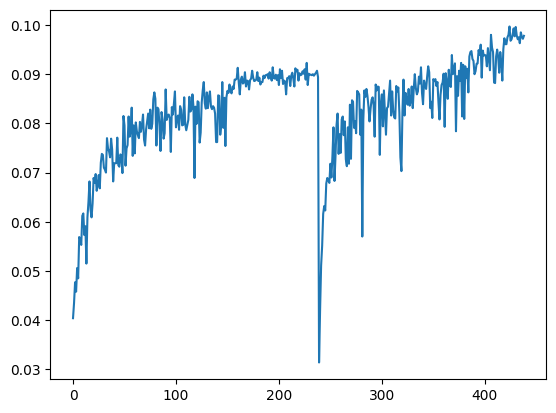

In [129]:

print(max(acc_listmn))
plt.plot(acc_listmn)

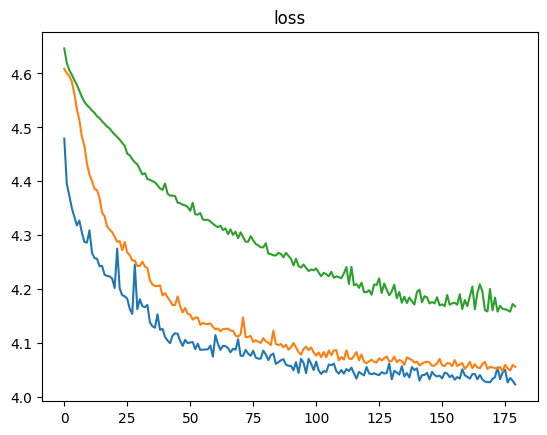

In [551]:
plt.title('loss')
plt.plot(loss_list)
plt.plot(loss_listm)
plt.plot(loss_listT)

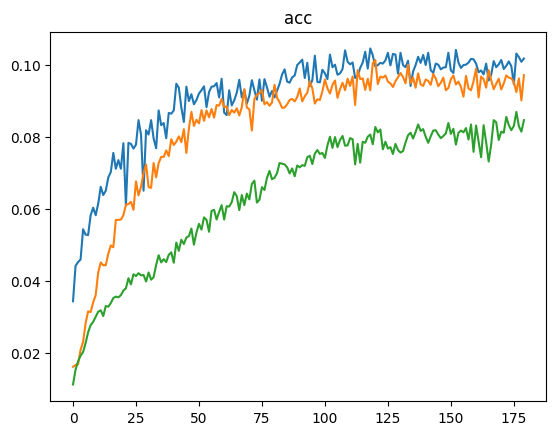

In [538]:
plt.title('acc')
plt.plot(acc_list)
plt.plot(acc_listm)
plt.plot(acc_listT)

NameError: name 'acc_list' is not defined

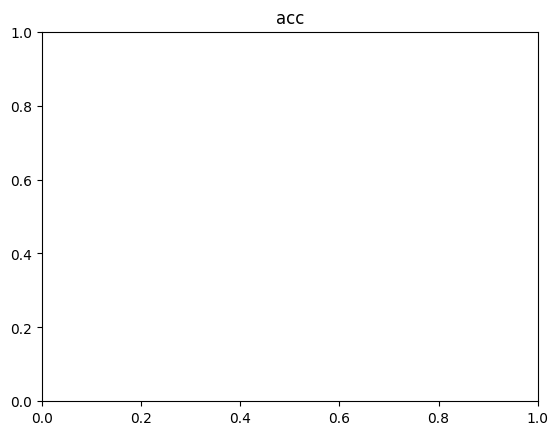

In [227]:
plt.title('acc')
plt.plot(acc_list)
plt.plot(acc_listm)
plt.plot(acc_listT)